In [1]:
from IPython.display import display

from notebooks.util.long_memory_utils import *
from liquidity.features import compute_returns

from hurst_exponent.hurst_exponent import standard_hurst, generalized_hurst
from hurst_exponent.util.utils import interpret_hurst, augmented_dickey_fuller

In [2]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

In [3]:
# Number of events to use
EVENTS_RANGE = 500000

# Lag/window size for Hurst and the ACF
LAG = 1000

## Load limit orders raw sample data

In [4]:
# Load raw sample data  from CSV
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'AAPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'limit_orders')
acf_data_dir = os.path.join(root_dir, 'data', 'generated', 'lo_data', 'long_memory')

stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2017-NEW.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['AAPL']

## 1. Returns

In [5]:
# Compute returns
tsla_returns = compute_returns(tsla_raw_df)['returns']
msft_returns = compute_returns(msft_raw_df)['returns']
amzn_returns = compute_returns(amzn_raw_df)['returns']
nflx_returns = compute_returns(nflx_raw_df)['returns']
ebay_returns = compute_returns(ebay_raw_df)['returns']
appl_returns = compute_returns(appl_raw_df)['returns']

returns = {
  'TSLA': tsla_returns,
  'MSFT': msft_returns,
  'AMZN': amzn_returns,
  'NFLX': nflx_returns,
  'EBAY': ebay_returns,
  'AAPL': appl_returns
}
returns = {stock: data.head(EVENTS_RANGE) for stock, data in returns.items()}

In [6]:
# Compute ACF for TSLA using the linear method
tsla_acf = compute_acf("TSLA", tsla_returns, option="linear")
display(tsla_acf)

('TSLA',
 0       1.000000
 1      -0.005111
 2      -0.005006
 3       0.001177
 4       0.003339
           ...   
 996    -0.000475
 997    -0.000154
 998    -0.000385
 999     0.000635
 1000    0.000394
 Length: 1001, dtype: float64)

### 1.1. Stationarity Test
To test whether our time series are stationary, we perform an augmented Dickey-Fuller test on each series, which uses the following null and alternative hypotheses:
- **H0:** The time series is non-stationary.
  - In other words, it has some time-dependent structure and does not have constant variance over time.
  - There is at least one unit root.
- **H1:** The time series is stationary.
- **Note:** If the p-value from the test is less than some significance level (e.g. $\alpha$ = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

In [7]:
# ADF test
for stock, data in returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -232.21
p-value: 0.00,
N: 499991, 
critical values: {'1%': -3.430363078902566, '5%': -2.8615457807209896, '10%': -2.5667730768666197}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -109.31
p-value: 0.00,
N: 499958, 
critical values: {'1%': -3.43036307976585, '5%': -2.8615457811025506, '10%': -2.5667730770697106}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -351.98
p-value: 0.00,
N: 499996, 
critical values: {'1%': -3.430363078771775, '5%': -2.861545780663182, '10%': -2.566773076835851}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -189.68
p-value: 0.00,
N: 499987, 
critical values: {'1%': -3.4303630790072, '5%': -2.861545780767237, '10%': -2.5667730768912356}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


EB

In [8]:
# Save data for lazy loading
linear_filename = f"{acf_data_dir}/lo_returns_linear_acfs.pkl"

# Linear ACF
linear_acfs = compute_acfs(filename=linear_filename, data=returns, option='linear')
print(linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


### 1.2. Return Autocorrelation Functions (ACFs)
There appears to be a clear difference between linear and nonlinear ACFs. If our data doesn’t contain significant non-linear patterns, both Pearson and Kendall methods could end up providing similar results.
**Key Points:**
- The **Kendall correlation** would detect non-linear relationships if they exist.
- If no non-linear relationships exist, it would just mirror the results of the Pearson correlation.
- Given this behavior, it’s best to use **Kendall** in case a non-linear relation holds for some data in our sample.

In [9]:
nonlinear_filename = f"{acf_data_dir}/lo_returns_nonlinear_acfs.pkl"

# Nonlinear ACF
nonlinear_acfs = compute_acfs(filename=nonlinear_filename, data=returns, option='nonlinear')
print(nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


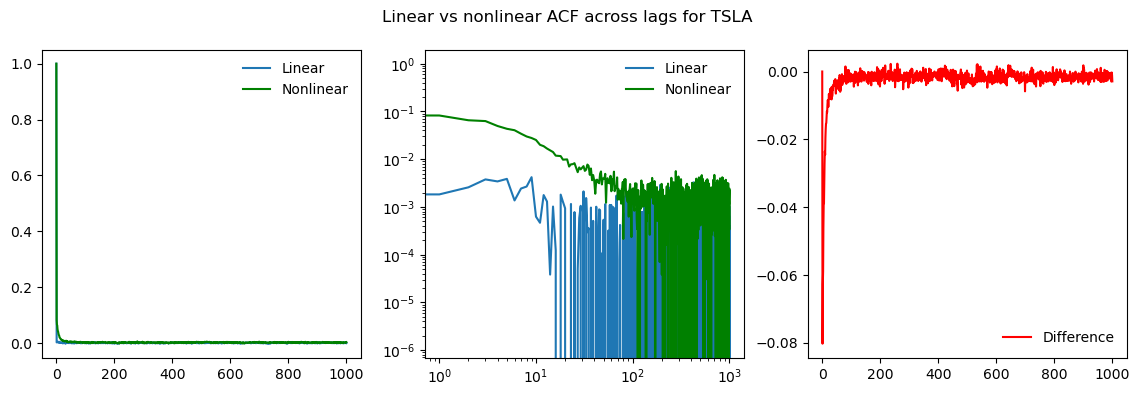

TSLA Max difference: 0.0023101516532177267


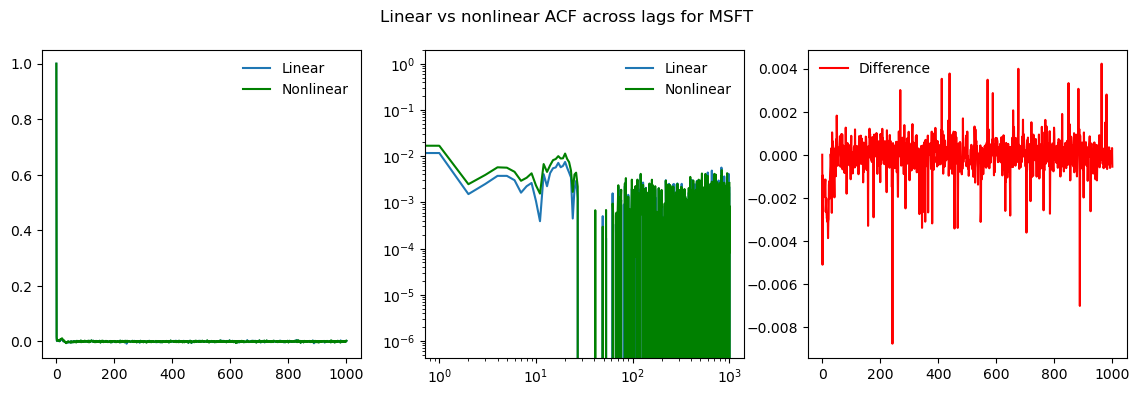

MSFT Max difference: 0.004231596057430147


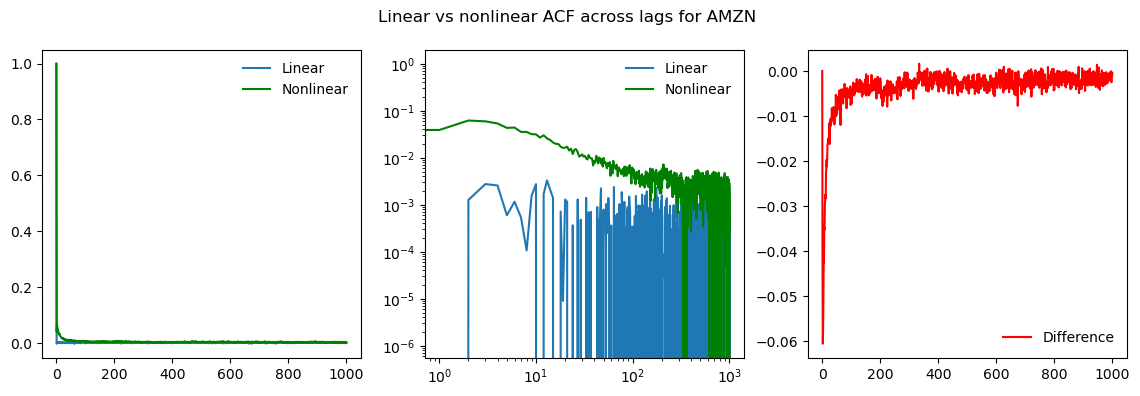

AMZN Max difference: 0.001614381437676901


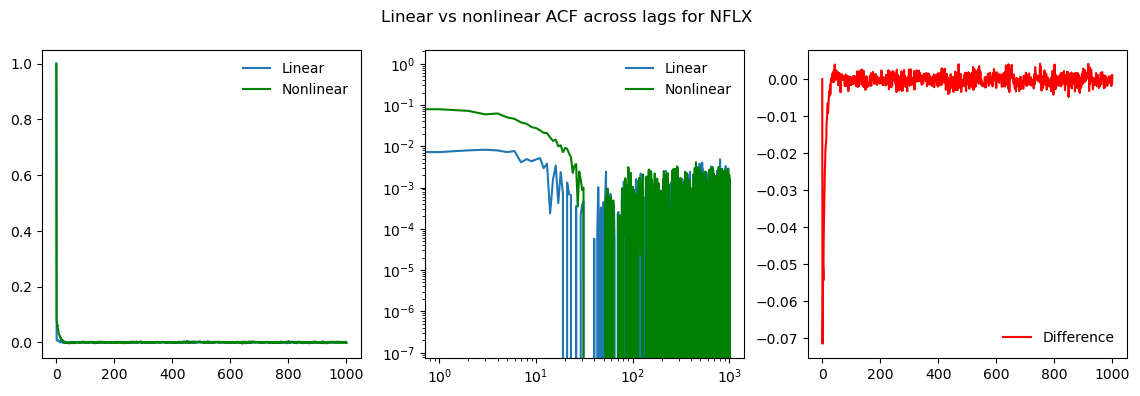

NFLX Max difference: 0.0041857641539561966


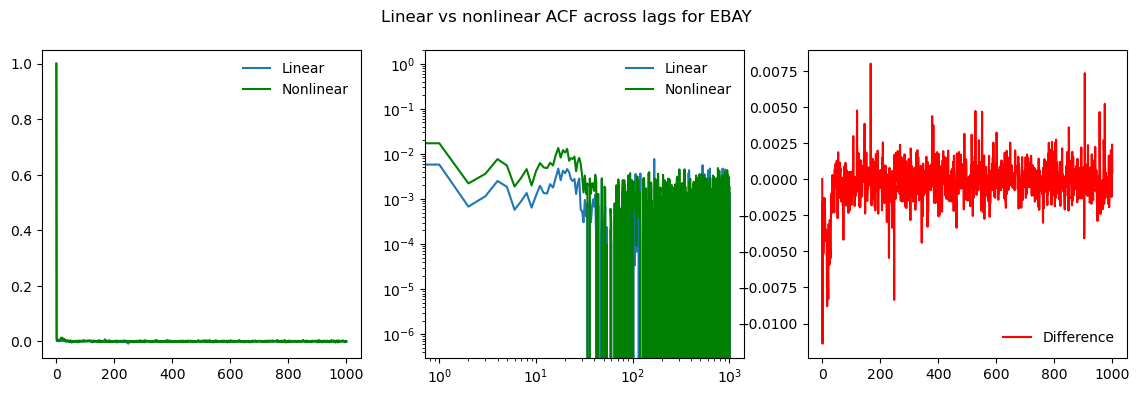

EBAY Max difference: 0.007994540499383352


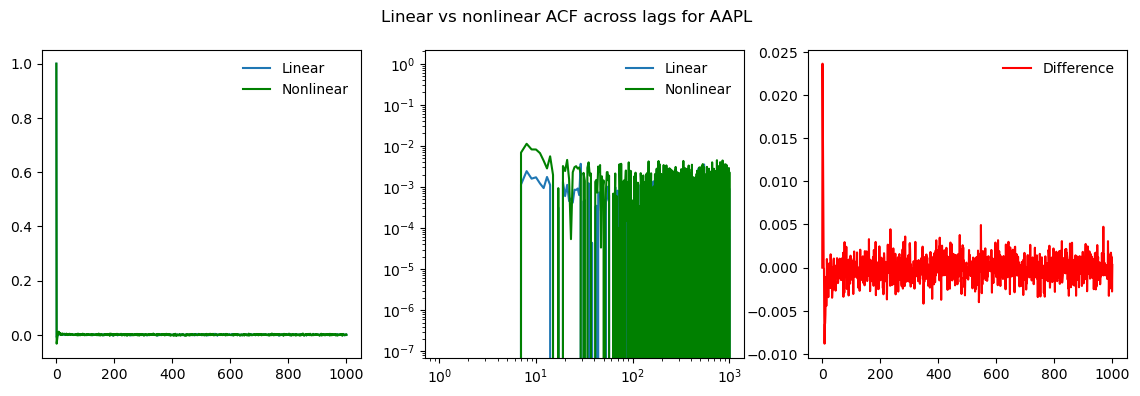

AAPL Max difference: 0.023621544248902646


In [10]:
# Plot differences
# plot_acf_difference("TSLA", linear_acfs, nonlinear_acfs)
for stock_name in linear_acfs.keys():
    plot_acf_difference(stock_name, linear_acfs, nonlinear_acfs)

### 1.3. The Long Memory of Returns?
To determine if a random process exhibits long memory, we take the following approach:
1. **Infer an Autocorrelation Function (ACF):** Start by inferring the ACF from a finite return sample.
2. **Fit a Power-law to the ACF:** Use the inferred ACF to fit a power-law.
3. **Estimate Hurst Exponent:** Use standard and generalized hurst on cumulative sum of raw series.

#### 1.3.1. Estimate ACF scaling parameter

In [11]:
# TSLA Example
tsla_returns_acf = nonlinear_acfs['TSLA']
x = list(range(1, len(tsla_returns_acf) + 1))
xy_df = pd.DataFrame({"x_values": x, "y_values": tsla_returns_acf})

tsla_acf_fit = Fit(xy_df)
tsla_acf_fit.powerlaw.fit_results()


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 14
xmin: 15.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.0424723585045384
alpha = -0.5751156209092878

Goodness of fit to data;
D = 0.24214792299898683
bic = -13109.624013481742
mape = 201.88153899026094
Adjusted R-squared = 0.34757682536364




#### 1.3.2. For all assets

In [12]:
# Load the pre-computed ACFs
return_acf_values = {}

for stock, data in nonlinear_acfs.items():
    return_acf_values[stock] = construct_xy(data, stock)

In [13]:
# Using return_acf_values
fit_results_list = []
fit_objects = {}  # Dictionary to store fit objects

for stock, data in return_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        fit_results_list.append(fit_dict)
        fit_objects[stock] = fit_obj  # Store the fit object

acf_fit_results = pd.DataFrame(fit_results_list)
display(acf_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0908287...",10,11.0,0.285570,-13016.852780,177.516490,0.510249,-0.733185,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -2.067331...",10,11.0,0.497477,-12556.035915,130.538740,-0.002154,0.524991,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1218607...",10,11.0,0.210898,-13144.365681,95.467162,0.802871,-0.661339,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 16.107669...",10,11.0,0.440969,-13098.469979,108.134339,0.635614,-2.596148,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1829910...",10,11.0,0.467205,-12662.823132,209.823837,0.236972,-1.185105,EBAY


In [14]:
fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])

In [15]:
avg_gamma = acf_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_gamma}")

Average Gamma: -1.0138172877652893


In [16]:
# Retrieve the fit object for 'STOCK':
# tsla_acf_fit = fit_objects['AMZN']
# tsla_acf_fit.powerlaw.plot_fit()

### 1.4. Estimate Hurst Exponent
The Hurst Exponent, denoted by $H$, is a statistical measure of a time series which can be used to determine the nature of the series. Its value can range between 0 and 1:
- $H = 0.5$: The series is a random walk (Brownian motion). The future values do not depend on the past values.
- $H < 0.5$: The series has a tendency to revert to a mean, indicating negative autocorrelation. This is typical of "mean-reverting" series.
- $H > 0.5$: The series shows a trending behavior, meaning that increases (decreases) in the past will likely be followed by increases (decreases) in the future.

In [17]:
# TSLA Example
tsla_returns = compute_returns(tsla_raw_df)['returns'].cumsum()

# Estimate Hurst Exponent using both Standard and Generalized metod
hurst_std, fit_std = standard_hurst(tsla_returns)
hurst_gen, fit_gen = generalized_hurst(tsla_returns)

fit_std.powerlaw.fit_results()
fit_gen.powerlaw.fit_results()

print(f"Standard Hurst Exponent: {hurst_std} ({interpret_hurst(hurst_std)})")
print(f"Generalized Hurst Exponent: {hurst_gen} ({interpret_hurst(hurst_gen)})")


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 1
xmin: 1.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.050299892650654154
alpha = 0.5087984136748799

Goodness of fit to data;
D = 0.010116337885685382
bic = -29675.46108574002
mape = 0.14589095893853354
Adjusted R-squared = 0.9999798802459379



For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 1
xmin: 1.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.01766199662245322
alpha = 0.5762840814399146

Goodness of fit to data;
D = 0.010116337885685382
bic = -26713.356653192102
mape = 1.2561883547848236
Adjusted R-squared = 0.9996496653029753


Standard Hurst Exponent: 0.5087984136748799 (Super-diffusive: series demonstrates persistent long-range dependence)
Generalized Hurst Exponent: 0.5762840814399146 (Super-diffusive: series demonstrates persistent long-range dependence)


#### 1.4.1 For all assets

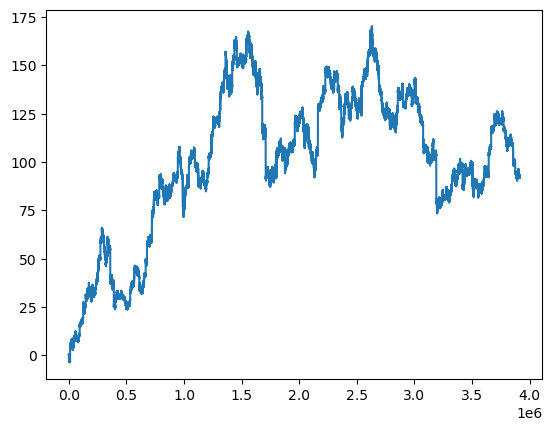

In [18]:
# Compute cumsum of returns as input for Hurst
tsla_cum_returns = compute_returns(tsla_raw_df)['returns']
amzn_cum_returns = compute_returns(msft_raw_df)['returns']
nflx_cum_returns = compute_returns(amzn_raw_df)['returns']
msft_cum_returns = compute_returns(nflx_raw_df)['returns']
ebay_cum_returns = compute_returns(ebay_raw_df)['returns']
appl_cum_returns = compute_returns(appl_raw_df)['returns']

cumsum_returns = {
  'TSLA': tsla_cum_returns.cumsum(),
  'MSFT': amzn_cum_returns.cumsum(),
  'AMZN': nflx_cum_returns.cumsum(),
  'NFLX': msft_cum_returns.cumsum(),
  'EBAY': ebay_cum_returns.cumsum(),
  'AAPL': appl_cum_returns.cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_returns = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_returns.items()}
tsla_cumsum_returns = tsla_cum_returns = compute_returns(tsla_raw_df)['returns'].cumsum()
x = list(range(1, len(tsla_cum_returns)+1))
plt.plot(x, tsla_cum_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [19]:
# Standard Hurst
method = 'standard'
fit_results_list = []
fit_objects = {}

for stock, data in cumsum_returns.items():
    fit_dict, fit = compute_hurst_exponent('returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        fit_results_list.append(fit_dict)
        fit_objects[(stock, method, 'returns')] = fit

std_hurst_fit_results = pd.DataFrame(fit_results_list)
display(std_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0527428...",1,2.0,0.008499,-6232.801300,1.013607,0.998804,0.483711,TSLA,returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0011515...",1,2.0,0.018414,-11300.491237,1.489704,0.997695,0.471551,MSFT,returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0827207...",1,2.0,0.014164,-5667.029736,0.891014,0.999025,0.490533,AMZN,returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0167149...",1,2.0,0.012748,-7412.074806,1.082473,0.998233,0.499346,NFLX,returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0012143...",1,2.0,0.012748,-11405.353972,0.786588,0.999059,0.513320,EBAY,returns


In [20]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.4910868807988193


In [21]:
print(fit_objects.keys())

dict_keys([('TSLA', 'standard', 'returns'), ('MSFT', 'standard', 'returns'), ('AMZN', 'standard', 'returns'), ('NFLX', 'standard', 'returns'), ('EBAY', 'standard', 'returns'), ('AAPL', 'standard', 'returns')])


In [22]:
# Retrieve standard Hurst fit object for specific 'STOCK'
tsla_standard_fit = fit_objects[('TSLA', 'standard', 'returns')]
tsla_standard_fit.powerlaw.plot_fit()

#### Generalized Hurst

In [23]:
# Generalized Hurst
method = 'generalized'
fit_results_list = []
fit_objects = {}

for stock, data in cumsum_returns.items():
    fit_dict, fit = compute_hurst_exponent('returns', stock, data, method=method,  max_lag=LAG)
    if fit_dict:
        fit_results_list.append(fit_dict)
        fit_objects[(stock, method, 'returns')] = fit

gen_hurst_fit_results = pd.DataFrame(fit_results_list)
display(gen_hurst_fit_results.head())

/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0143330...",1,2.0,0.015581,-7689.848515,1.057128,0.999543,0.582785,TSLA,returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0007307...",38,54.0,0.010463,-13052.479232,0.397059,0.999857,0.499707,MSFT,returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0204188...",1,2.0,0.004249,-9153.524446,0.319768,0.999979,0.601878,AMZN,returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0061369...",1,2.0,0.007082,-10200.699866,0.698754,0.999867,0.541033,NFLX,returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0005231...",58,83.0,0.007704,-12667.603235,0.320786,0.999881,0.560372,EBAY,returns


In [24]:
# Generalized Hurst statistic across stocks
min_hurst_gen = gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.49970695317013736
Max Generalized Hurst: 0.6018782666931284
Average Generalized Hurst: 0.5588427038562139
Standard_dev Generalized Hurst: 0.035533291464325795


In [25]:
print(fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'returns'), ('MSFT', 'generalized', 'returns'), ('AMZN', 'generalized', 'returns'), ('NFLX', 'generalized', 'returns'), ('EBAY', 'generalized', 'returns'), ('AAPL', 'generalized', 'returns')])


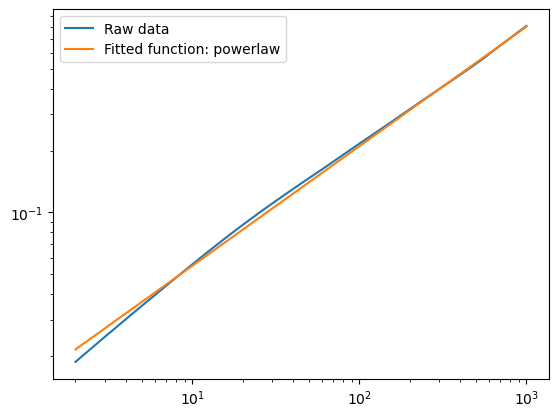

In [28]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = fit_objects[('TSLA', 'generalized', 'returns')]
tsla_generalized_fit.powerlaw.plot_fit()

## 2. Percentage Returns

In [29]:
# Compute percentage returns
tsla_percentage_returns = compute_returns(tsla_raw_df)['pct_returns']
msft_percentage_returns = compute_returns(msft_raw_df)['pct_returns']
amzn_percentage_returns = compute_returns(amzn_raw_df)['pct_returns']
nflx_percentage_returns = compute_returns(nflx_raw_df)['pct_returns']
ebay_percentage_returns = compute_returns(ebay_raw_df)['pct_returns']
appl_percentage_returns = compute_returns(appl_raw_df)['pct_returns']

percentage_returns = {
  'TSLA': tsla_percentage_returns,
  'MSFT': msft_percentage_returns,
  'AMZN': amzn_percentage_returns,
  'NFLX': nflx_percentage_returns,
  'EBAY': ebay_percentage_returns,
  'AAPL': appl_percentage_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
percentage_returns = {stock: data.head(EVENTS_RANGE) for stock, data in percentage_returns.items()}

### Stationarity Test

In [30]:
# ADF test
for stock, data in percentage_returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -232.14
p-value: 0.00,
N: 499991, 
critical values: {'1%': -3.430363078902566, '5%': -2.8615457807209896, '10%': -2.5667730768666197}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -109.32
p-value: 0.00,
N: 499958, 
critical values: {'1%': -3.43036307976585, '5%': -2.8615457811025506, '10%': -2.5667730770697106}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -351.94
p-value: 0.00,
N: 499996, 
critical values: {'1%': -3.430363078771775, '5%': -2.861545780663182, '10%': -2.566773076835851}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -189.83
p-value: 0.00,
N: 499987, 
critical values: {'1%': -3.4303630790072, '5%': -2.861545780767237, '10%': -2.5667730768912356}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


EB

### 2.1. Percentage returns ACF

In [31]:
# Linear ACF
percentage_returns_linear_acf_filename = f"{acf_data_dir}/lo_percentage_returns_linear_acfs.pkl"
percentage_returns_linear_acfs = compute_acfs(filename=percentage_returns_linear_acf_filename, data=percentage_returns, option='linear')
print(percentage_returns_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


In [32]:
# Nonlinear ACF
percentage_returns_nonlinear_acf_filename = f"{acf_data_dir}/lo_percentage_returns_nonlinear_acfs.pkl"
percentage_returns_nonlinear_acfs = compute_acfs(filename=percentage_returns_nonlinear_acf_filename, data=percentage_returns, option='nonlinear')
print(percentage_returns_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


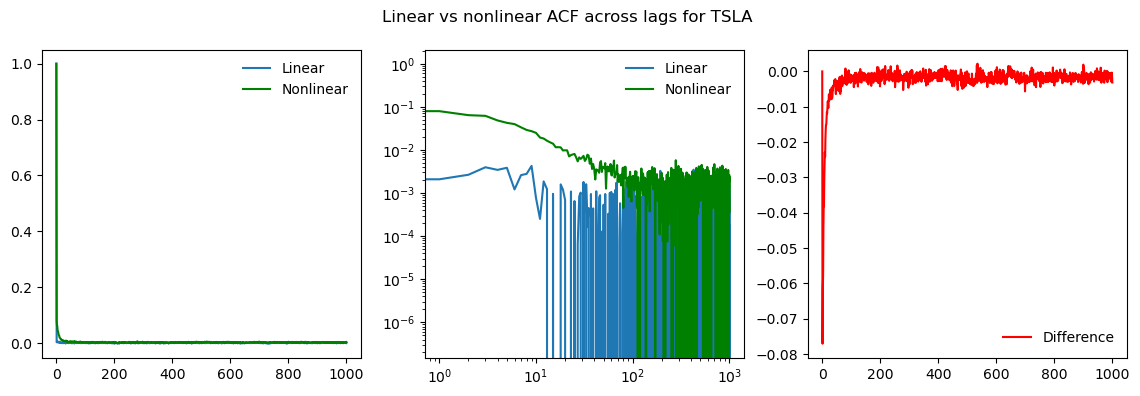

TSLA Max difference: 0.002191145911098525


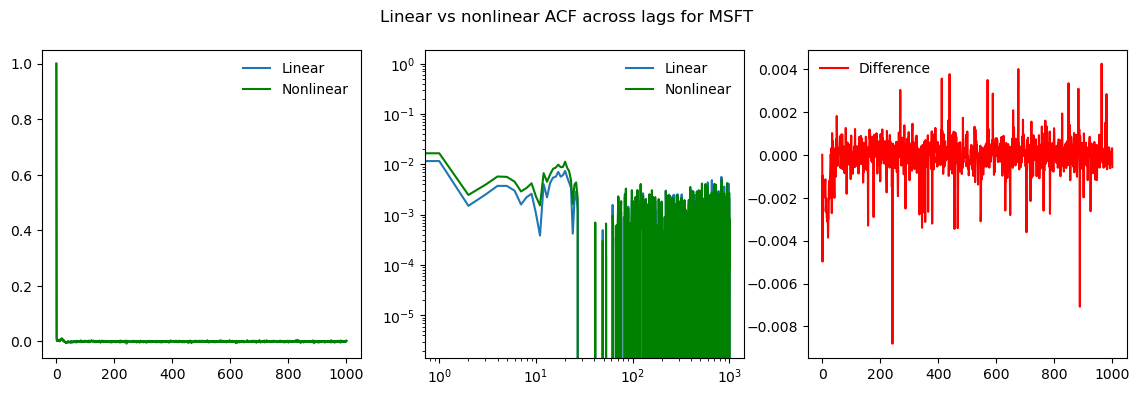

MSFT Max difference: 0.004244076293166429


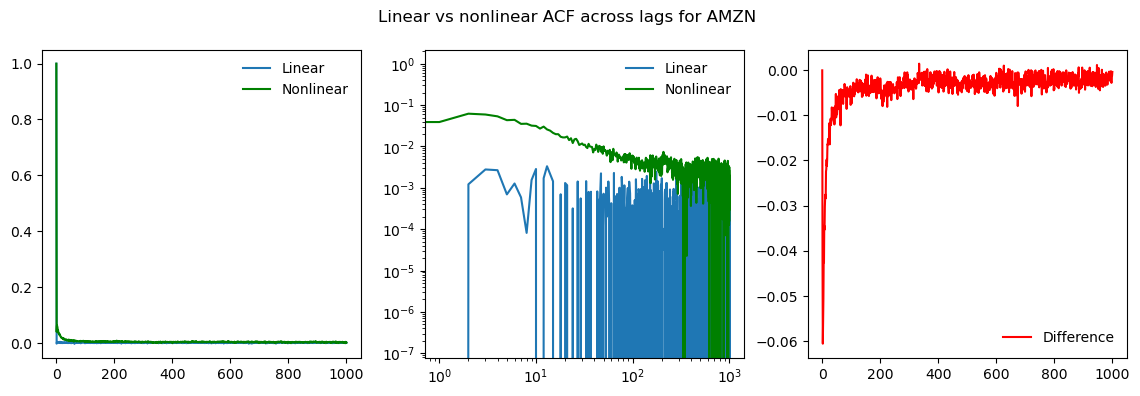

AMZN Max difference: 0.0014765514977279248


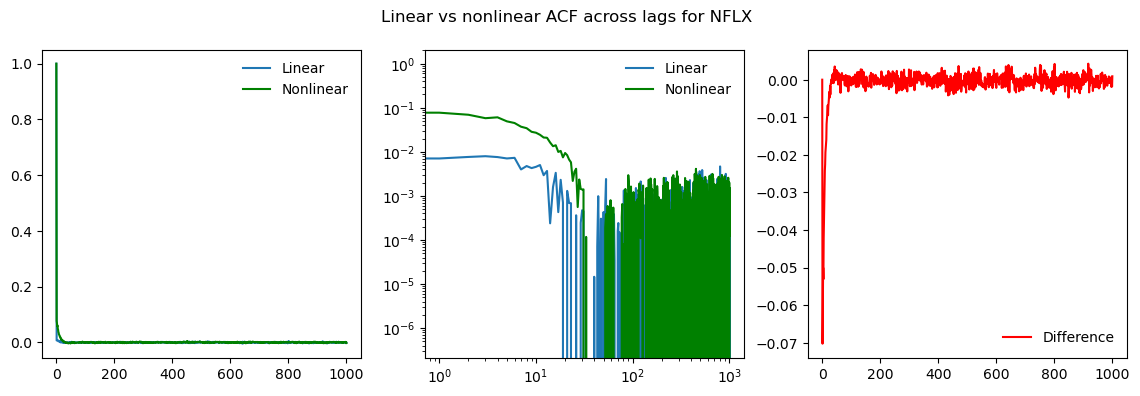

NFLX Max difference: 0.004262127451317394


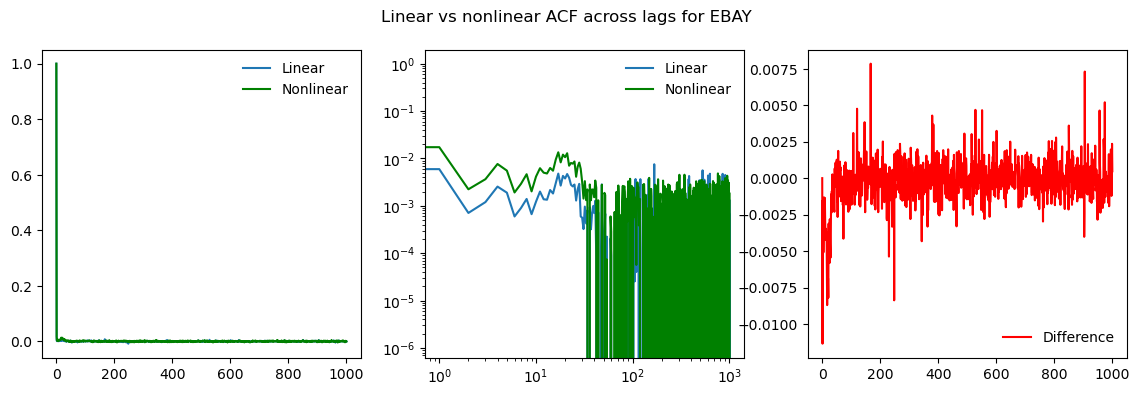

EBAY Max difference: 0.007845096508952543


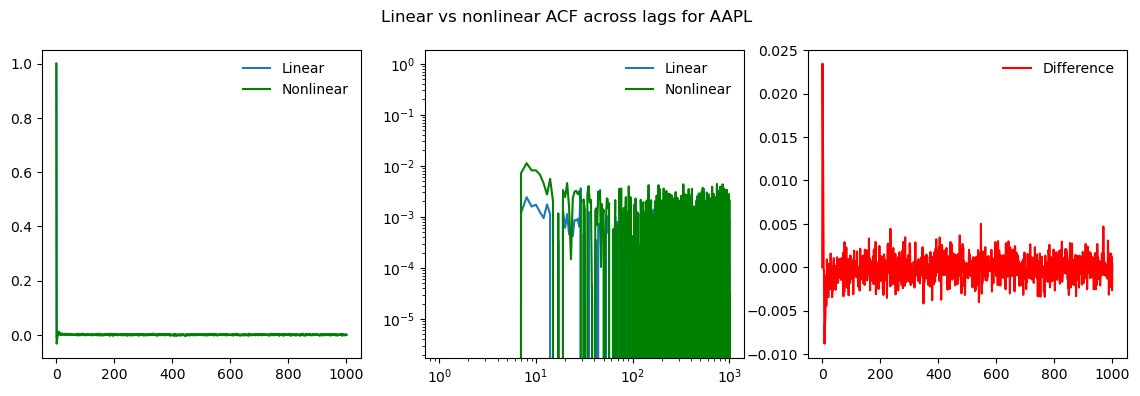

AAPL Max difference: 0.023454928475270878


In [33]:
for stock_name in percentage_returns_linear_acfs.keys():
    plot_acf_difference(stock_name, percentage_returns_linear_acfs, percentage_returns_nonlinear_acfs)

### 2.2. Fit power law to percentage returns ACF

In [34]:
# Load the pre-computed ACFs
percentage_returns_acf_values = {}

for stock, data in percentage_returns_nonlinear_acfs.items():
    percentage_returns_acf_values[stock] = construct_xy(data, stock)

In [35]:
# Using percentage_return_acf_values
percentage_returns_fit_list = []
percentage_returns_fit_objects = {}

for stock, data in percentage_returns_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        percentage_returns_fit_list.append(fit_dict)
        percentage_returns_fit_objects[stock] = fit_obj  # Store the fit object

percentage_returns_fit_results = pd.DataFrame(percentage_returns_fit_list)
display(percentage_returns_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0760854...",10,11.0,0.267407,-13071.574077,266.584135,0.510441,-0.683235,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -2.114703...",10,11.0,0.493441,-12562.819813,117.303415,-0.002140,0.522800,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1139285...",10,11.0,0.211907,-13131.902237,109.307756,0.799046,-0.639029,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 14.982738...",10,11.0,0.441978,-13137.011668,104.287069,0.642051,-2.568984,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1840013...",10,11.0,0.467205,-12667.349804,204.368768,0.237074,-1.187654,EBAY


In [36]:
percentage_returns_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])

In [37]:
avg_alpha = percentage_returns_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.9990342794048267


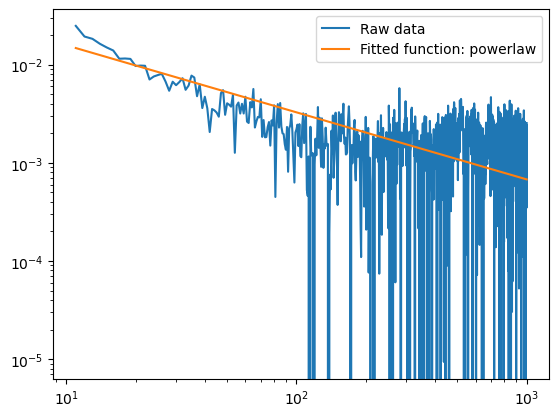

In [38]:
tsla_acf_fit = percentage_returns_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

### 2.3 Percentage returns Hurst Exponents

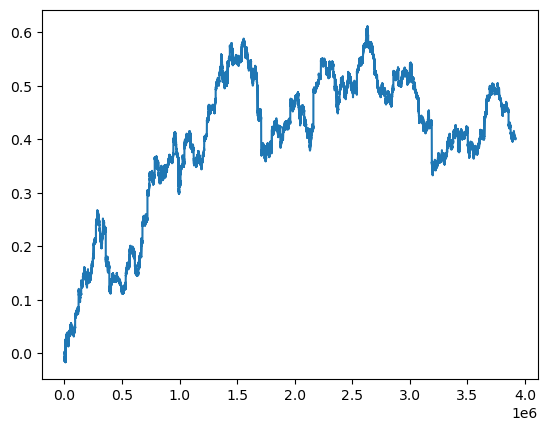

In [39]:
# Compute cumsum of percentage returns
cumsum_percentage_returns = {
  'TSLA': tsla_percentage_returns.cumsum(),
  'MSFT': msft_percentage_returns.cumsum(),
  'AMZN': amzn_percentage_returns.cumsum(),
  'NFLX': nflx_percentage_returns.cumsum(),
  'EBAY': ebay_percentage_returns.cumsum(),
  'AAPL': appl_percentage_returns.cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_percentage_returns = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_percentage_returns.items()}
tsla_cumsum_percentage_returns = tsla_percentage_returns.cumsum()
x = list(range(1, len(tsla_cumsum_percentage_returns)+1))
plt.plot(x, tsla_cumsum_percentage_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [40]:
# Standard Hurst
method = 'standard'
percentage_returns_fit_results_list = []
percentage_returns_fit_objects = {}

for stock, data in cumsum_percentage_returns.items():
    fit_dict, fit = compute_hurst_exponent('percentage_returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        percentage_returns_fit_results_list.append(fit_dict)
        percentage_returns_fit_objects[(stock, method, 'percentage_returns')] = fit

percentage_returns_std_hurst_fit_results = pd.DataFrame(percentage_returns_fit_results_list)
display(percentage_returns_std_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0002079...",1,2.0,0.009915,-14088.128341,0.986516,0.998865,0.483578,TSLA,percentage_returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.8453170...",1,2.0,0.018414,-17138.732899,1.490461,0.997694,0.471372,MSFT,percentage_returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001006...",1,2.0,0.014164,-15161.191088,0.881409,0.999052,0.490662,AMZN,percentage_returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001252...",1,2.0,0.012748,-14367.982203,1.055400,0.998340,0.499154,NFLX,percentage_returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 4.0003211...",1,2.0,0.012748,-16223.993109,0.794230,0.999054,0.512981,EBAY,percentage_returns


In [41]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = percentage_returns_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.4909864392193832


In [42]:
display(percentage_returns_fit_objects.keys())

dict_keys([('TSLA', 'standard', 'percentage_returns'), ('MSFT', 'standard', 'percentage_returns'), ('AMZN', 'standard', 'percentage_returns'), ('NFLX', 'standard', 'percentage_returns'), ('EBAY', 'standard', 'percentage_returns'), ('AAPL', 'standard', 'percentage_returns')])

#### Generalized Hurst

In [43]:
# Generalized Hurst
method = 'generalized'
percentage_returns_fit_results_list = []
percentage_returns_fit_objects = {}

for stock, data in cumsum_percentage_returns.items():
    fit_dict, fit = compute_hurst_exponent('percentage_returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        percentage_returns_fit_results_list.append(fit_dict)
        percentage_returns_fit_objects[(stock, method, 'percentage_returns')] = fit

percentage_returns_gen_hurst_fit_results = pd.DataFrame(percentage_returns_fit_results_list)
display(percentage_returns_gen_hurst_fit_results.head(10))

/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/po

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 5.7673242...",1,2.0,0.015581,-15496.263045,1.052478,0.999545,0.581257,TSLA,percentage_returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.1679783...",35,50.0,0.010417,-18603.520918,0.420623,0.999845,0.499906,MSFT,percentage_returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 2.4916857...",1,2.0,0.004249,-18608.530566,0.323912,0.999978,0.601862,AMZN,percentage_returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 4.5259770...",1,2.0,0.007082,-17102.445273,0.710931,0.999861,0.541139,NFLX,percentage_returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.7299651...",51,73.0,0.007622,-17117.584330,0.376872,0.999854,0.560415,EBAY,percentage_returns
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 8.0204845...",1,2.0,0.005666,-19487.539154,0.717002,0.999900,0.567500,AAPL,percentage_returns


In [44]:
# Generalized Hurst statistic across stocks
min_hurst_gen = percentage_returns_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = percentage_returns_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = percentage_returns_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = percentage_returns_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.4999062363767003
Max Generalized Hurst: 0.6018616119252619
Average Generalized Hurst: 0.5586797684878954
Standard_dev Generalized Hurst: 0.03526246460307482


In [45]:
print(percentage_returns_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'percentage_returns'), ('MSFT', 'generalized', 'percentage_returns'), ('AMZN', 'generalized', 'percentage_returns'), ('NFLX', 'generalized', 'percentage_returns'), ('EBAY', 'generalized', 'percentage_returns'), ('AAPL', 'generalized', 'percentage_returns')])


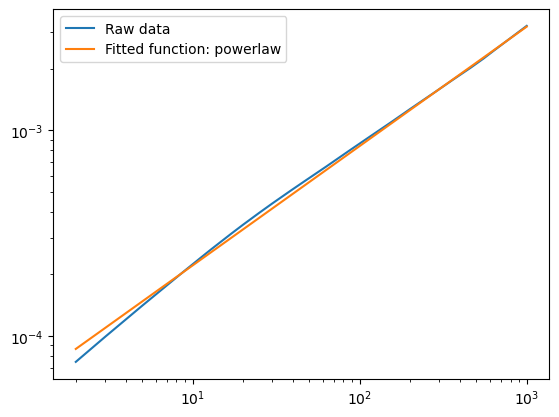

In [46]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = percentage_returns_fit_objects[('TSLA', 'generalized', 'percentage_returns')]
tsla_generalized_fit.powerlaw.plot_fit()

## 3. Log Returns

In [47]:
# Compute log returns
tsla_log_returns = compute_returns(tsla_raw_df)['log_returns']
msft_log_returns = compute_returns(msft_raw_df)['log_returns']
amzn_log_returns = compute_returns(amzn_raw_df)['log_returns']
nflx_log_returns = compute_returns(nflx_raw_df)['log_returns']
ebay_log_returns = compute_returns(ebay_raw_df)['log_returns']
appl_log_returns = compute_returns(appl_raw_df)['log_returns']

log_returns = {
  'TSLA': tsla_log_returns,
  'MSFT': msft_log_returns,
  'AMZN': amzn_log_returns,
  'NFLX': nflx_log_returns,
  'EBAY': ebay_log_returns,
  'AAPL': appl_log_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
log_returns = {stock: data.head(EVENTS_RANGE) for stock, data in log_returns.items()}

### Stationarity Test

In [48]:
# ADF test
for stock, data in log_returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -232.14
p-value: 0.00,
N: 499990, 
critical values: {'1%': -3.4303630789287243, '5%': -2.8615457807325515, '10%': -2.566773076872774}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -109.32
p-value: 0.00,
N: 499957, 
critical values: {'1%': -3.4303630797920124, '5%': -2.861545781114114, '10%': -2.5667730770758657}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -351.95
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -189.65
p-value: 0.00,
N: 499986, 
critical values: {'1%': -3.4303630790333592, '5%': -2.861545780778799, '10%': -2.5667730768973893}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary

### 3.1. Log returns ACF

In [49]:
# Linear ACF
log_returns_linear_acf_filename = f"{acf_data_dir}/lo_log_returns_linear_acfs.pkl"
log_returns_linear_acfs = compute_acfs(filename=log_returns_linear_acf_filename, data=log_returns, option='linear')
print(log_returns_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


In [50]:
# Nonlinear ACF
log_returns_nonlinear_acf_filename = f"{acf_data_dir}/lo_log_returns_nonlinear_acfs.pkl"
log_returns_nonlinear_acfs = compute_acfs(filename=log_returns_nonlinear_acf_filename, data=log_returns, option='nonlinear')
print(log_returns_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


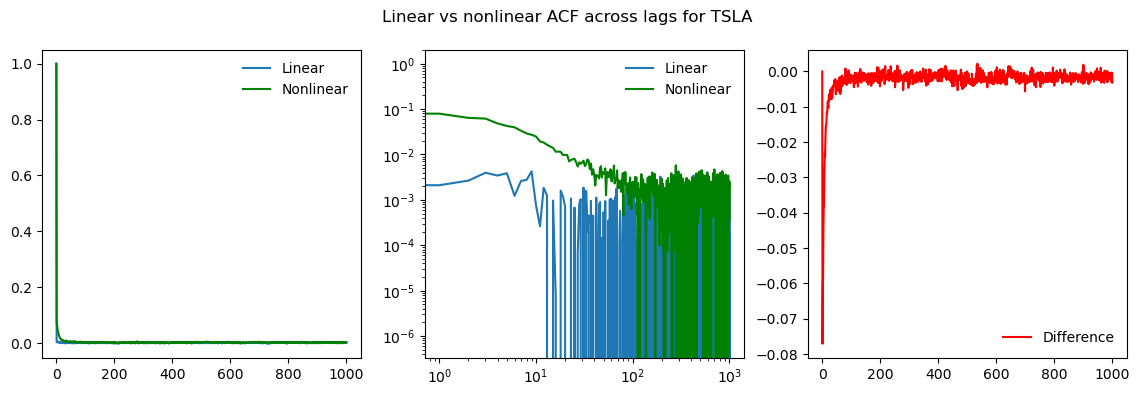

TSLA Max difference: 0.0022085813737687783


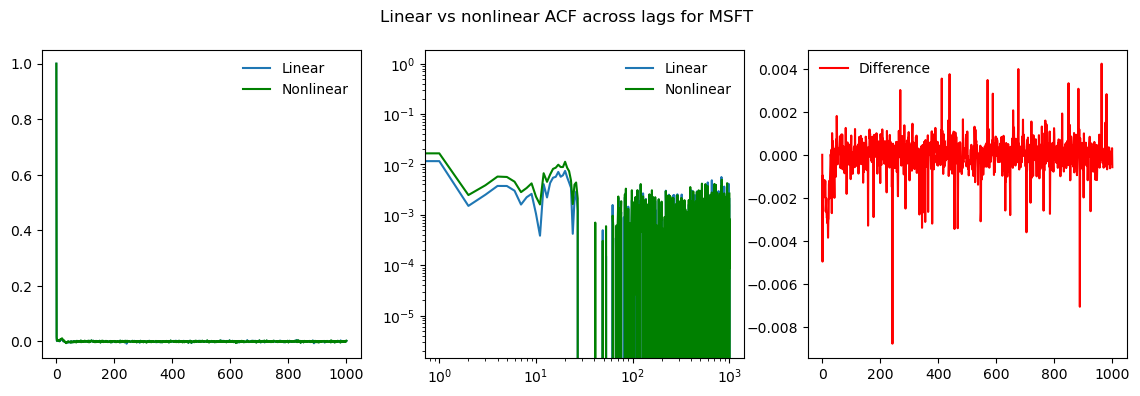

MSFT Max difference: 0.004239980151327797


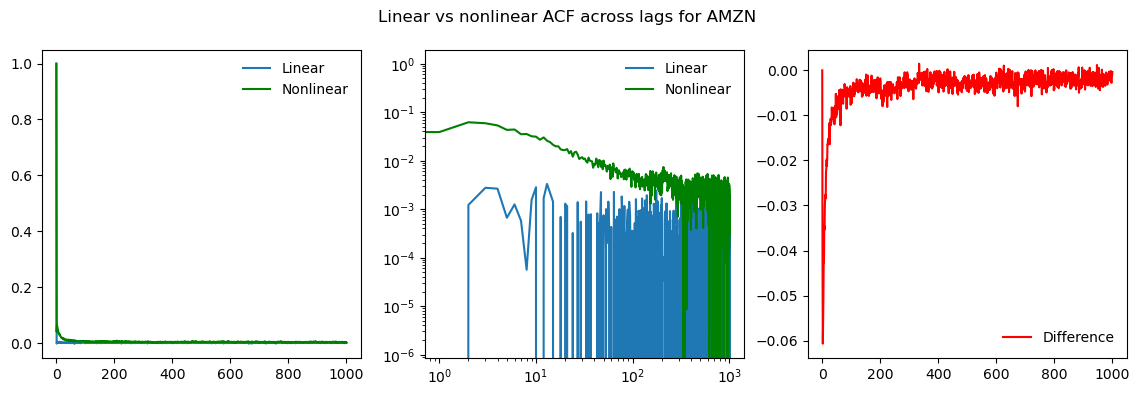

AMZN Max difference: 0.0014699558836638836


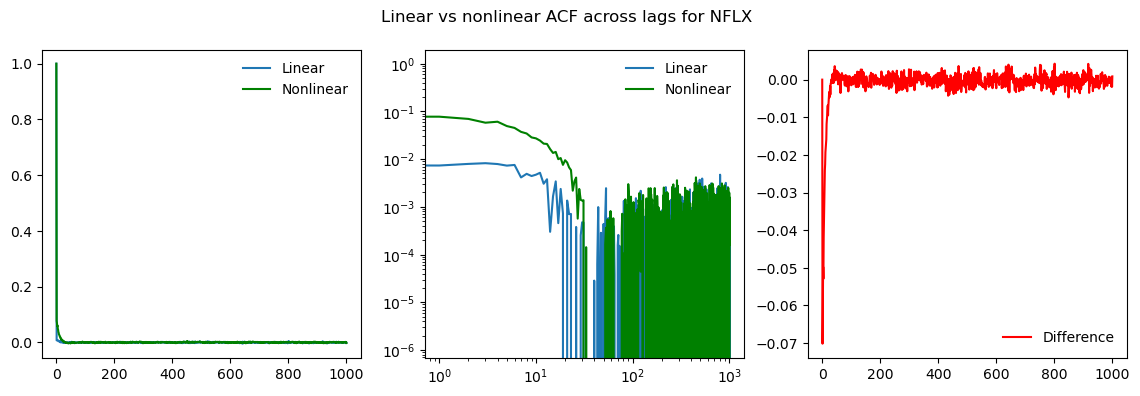

NFLX Max difference: 0.0042405271185402766


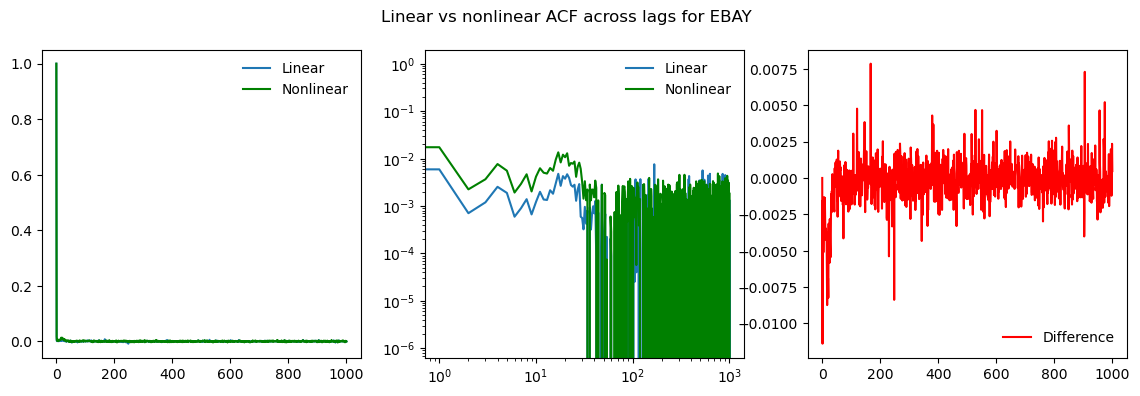

EBAY Max difference: 0.007857088117214734


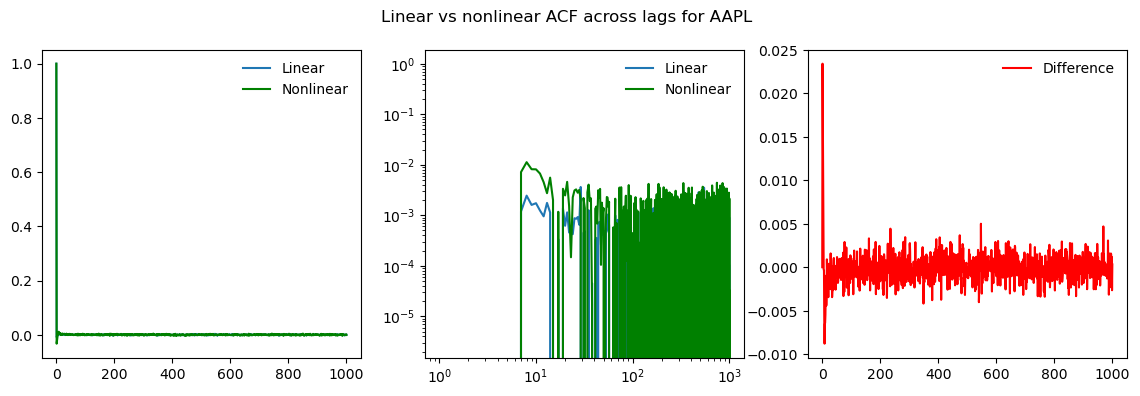

AAPL Max difference: 0.02339450656986041


In [51]:
for stock_name in log_returns_linear_acfs.keys():
    plot_acf_difference(stock_name, log_returns_linear_acfs, log_returns_nonlinear_acfs)

### 3.2. Fit power law to log retrurns ACF

In [52]:
# Load the pre-computed ACFs
log_returns_acf_values = {}

for stock, data in log_returns_nonlinear_acfs.items():
    log_returns_acf_values[stock] = construct_xy(data, stock)

In [53]:
# Using log_returns_nonlinear_acfs
log_returns_fit_results_list = []
log_returns_fit_objects = {}  # Dictionary to store fit objects

for stock, data in log_returns_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        log_returns_fit_results_list.append(fit_dict)
        log_returns_fit_objects[stock] = fit_obj  # Store the fit object

log_returns_fit_results = pd.DataFrame(log_returns_fit_results_list)
display(log_returns_fit_results.head(10))

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0760723...",10,11.0,0.268416,-13071.409161,208.328071,0.510206,-0.683221,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -2.162973...",10,11.0,0.493441,-12562.496607,117.720330,-0.002113,0.522247,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1141402...",10,11.0,0.212916,-13130.551734,119.301483,0.799024,-0.639448,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 15.057284...",10,11.0,0.446014,-13132.993658,103.131626,0.641444,-2.570514,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1840013...",10,11.0,0.467205,-12667.347218,204.259432,0.237074,-1.187654,EBAY
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1926624...",10,11.0,0.503532,-12838.023340,117.295371,0.088422,-1.438438,AAPL


In [54]:
log_returns_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])

In [55]:
avg_alpha = log_returns_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.9995047478520328


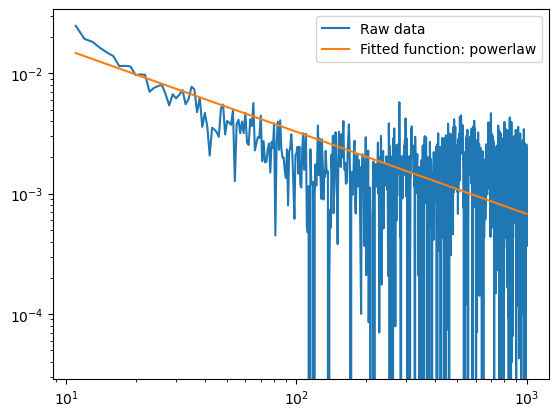

In [56]:
tsla_acf_fit = log_returns_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

### 3.3. Log returns Hurst Exponents

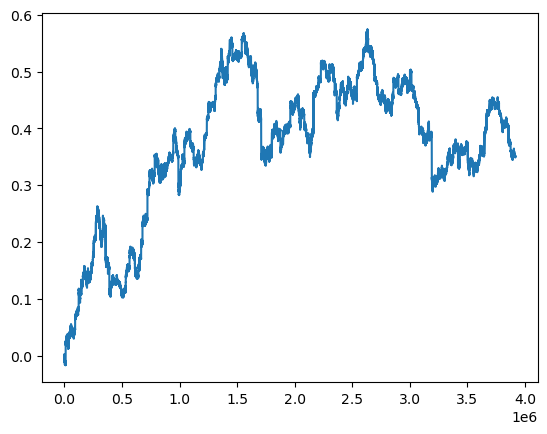

In [57]:
cumsum_log_returns = {
  'TSLA': tsla_log_returns.cumsum(),
  'MSFT': msft_log_returns.cumsum(),
  'AMZN': amzn_log_returns.cumsum(),
  'NFLX': nflx_log_returns.cumsum(),
  'EBAY': ebay_log_returns.cumsum(),
  'AAPL': appl_log_returns.cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_log_returns = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_log_returns.items()}
tsla_cumsum_log_returns = compute_returns(tsla_raw_df)['log_returns'].cumsum()
x = list(range(1, len(tsla_cumsum_log_returns)+1))
plt.plot(x, tsla_cumsum_log_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [58]:
# Standard Hurst
method = 'standard'
log_returns_fit_results_list = []
log_returns_fit_objects = {}

for stock, data in cumsum_log_returns.items():
    fit_dict, fit = compute_hurst_exponent('log_returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        log_returns_fit_results_list.append(fit_dict)
        log_returns_fit_objects[(stock, method, 'log_returns')] = fit

log_returns_std_hurst_fit_results = pd.DataFrame(log_returns_fit_results_list)
display(log_returns_std_hurst_fit_results.head(10))

/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0002076...",1,2.0,0.011331,-14085.331051,0.984024,0.998864,0.483950,TSLA,log_returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.8451703...",1,2.0,0.019830,-17126.351191,1.500922,0.997653,0.471363,MSFT,log_returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001009...",1,2.0,0.014164,-15152.740540,0.882351,0.999046,0.490738,AMZN,log_returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001234...",1,2.0,0.012748,-14369.530652,1.067234,0.998287,0.498842,NFLX,log_returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 4.0124487...",1,2.0,0.012748,-16233.235947,0.777685,0.999072,0.513020,EBAY,log_returns
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 2.7709492...",1,2.0,0.022663,-16673.382212,1.168766,0.998478,0.488156,AAPL,log_returns


In [59]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = log_returns_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.4910114136493721


In [60]:
display(log_returns_fit_objects.keys())

dict_keys([('TSLA', 'standard', 'log_returns'), ('MSFT', 'standard', 'log_returns'), ('AMZN', 'standard', 'log_returns'), ('NFLX', 'standard', 'log_returns'), ('EBAY', 'standard', 'log_returns'), ('AAPL', 'standard', 'log_returns')])

#### Generalized Hurst

In [61]:
# Generalized Hurst
method = 'generalized'
log_returns_fit_results_list = []
log_returns_fit_objects = {}

for stock, data in cumsum_log_returns.items():
    fit_dict, fit = compute_hurst_exponent('log_returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        log_returns_fit_results_list.append(fit_dict)
        log_returns_fit_objects[(stock, method, 'log_returns')] = fit

log_returns_gen_hurst_fit_results = pd.DataFrame(log_returns_fit_results_list)
display(log_returns_gen_hurst_fit_results.head(10))

/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/a

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 5.7714763...",1,2.0,0.015581,-15498.959360,1.050544,0.999546,0.581075,TSLA,log_returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.1680199...",35,50.0,0.010417,-18603.487177,0.420650,0.999845,0.499893,MSFT,log_returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 2.4913575...",1,2.0,0.004249,-18608.412935,0.323885,0.999978,0.601907,AMZN,log_returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 4.5380102...",1,2.0,0.007082,-17114.085584,0.708972,0.999863,0.540430,NFLX,log_returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.7291919...",51,73.0,0.007622,-17119.034217,0.376175,0.999854,0.560532,EBAY,log_returns
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 8.0260908...",1,2.0,0.005666,-19483.105420,0.720001,0.999899,0.567310,AAPL,log_returns


In [62]:
# Generalized Hurst statistic across stocks
min_hurst_gen = log_returns_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = log_returns_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = log_returns_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = log_returns_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.4998928279849176
Max Generalized Hurst: 0.6019069532857209
Average Generalized Hurst: 0.5585245873656939
Standard_dev Generalized Hurst: 0.035318176386465644


In [63]:
display(log_returns_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'log_returns'), ('MSFT', 'generalized', 'log_returns'), ('AMZN', 'generalized', 'log_returns'), ('NFLX', 'generalized', 'log_returns'), ('EBAY', 'generalized', 'log_returns'), ('AAPL', 'generalized', 'log_returns')])

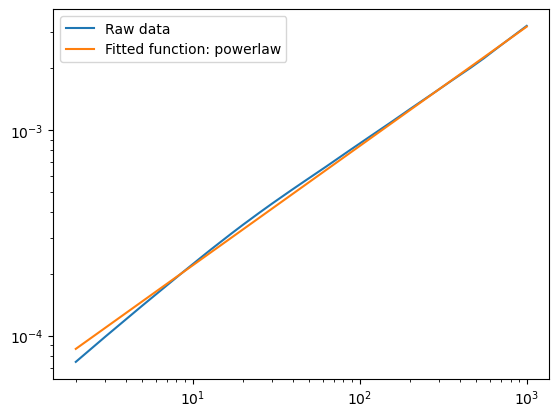

In [64]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = log_returns_fit_objects[('TSLA', 'generalized', 'log_returns')]
tsla_generalized_fit.powerlaw.plot_fit()

## 4. Return magnitudes

In [65]:
# Return magnitude (volatility)
tsla_volatility = compute_returns(tsla_raw_df)['volatility']
msft_volatility = compute_returns(msft_raw_df)['volatility']
amzn_volatility = compute_returns(amzn_raw_df)['volatility']
nflx_volatility = compute_returns(nflx_raw_df)['volatility']
ebay_volatility = compute_returns(ebay_raw_df)['volatility']
appl_volatility = compute_returns(appl_raw_df)['volatility']

return_magnitudes = {
  'TSLA': tsla_volatility,
  'MSFT': msft_volatility,
  'AMZN': amzn_volatility,
  'NFLX': nflx_volatility,
  'EBAY': ebay_volatility,
  'AAPL': appl_volatility
}
# Update the dictionary to only keep the first EVENTS_RANGE items
returns_magnitudes = {stock: data.head(EVENTS_RANGE) for stock, data in return_magnitudes.items()}

### Stationarity Test

In [66]:
# ADF test
for stock, data in return_magnitudes.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -67.46
p-value: 0.00,
N: 499911, 
critical values: {'1%': -3.4303630809955736, '5%': -2.8615457816460723, '10%': -2.566773077359008}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -60.43
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -81.01
p-value: 0.00,
N: 499936, 
critical values: {'1%': -3.430363080341437, '5%': -2.8615457813569525, '10%': -2.5667730772051196}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -81.79
p-value: 0.00,
N: 499936, 
critical values: {'1%': -3.430363080341437, '5%': -2.8615457813569525, '10%': -2.5667730772051196}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.




### 4.1. Return magnitude ACF

In [67]:
# Linear ACF
volatility_linear_acf_filename = f"{acf_data_dir}/lo_volatility_linear_acfs.pkl"
volatility_linear_acfs = compute_acfs(filename=volatility_linear_acf_filename, data=return_magnitudes, option='linear')
display(volatility_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])

In [68]:
# Nonlinear ACF
volatility_nonlinear_acf_filename = f"{acf_data_dir}/lo_volatility_nonlinear_acfs.pkl"
volatility_nonlinear_acfs = compute_acfs(filename=volatility_nonlinear_acf_filename, data=return_magnitudes, option='nonlinear')
display(volatility_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])

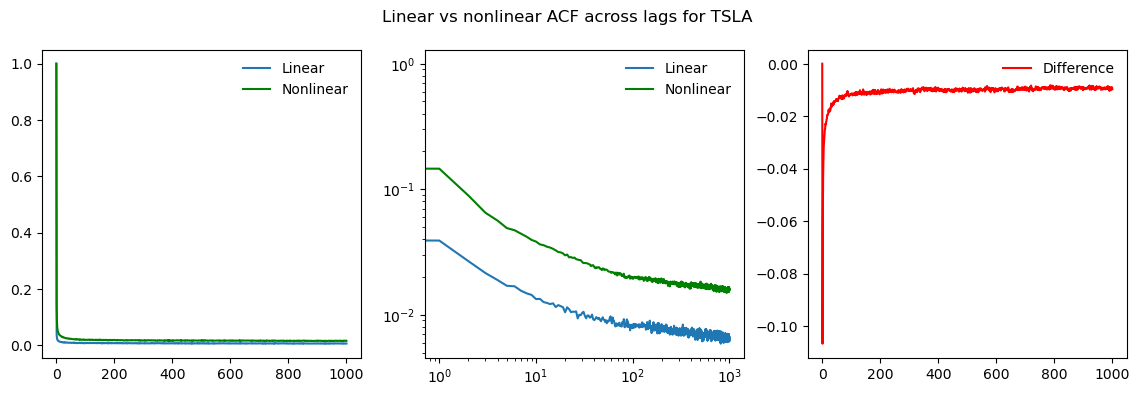

TSLA Max difference: 0.0


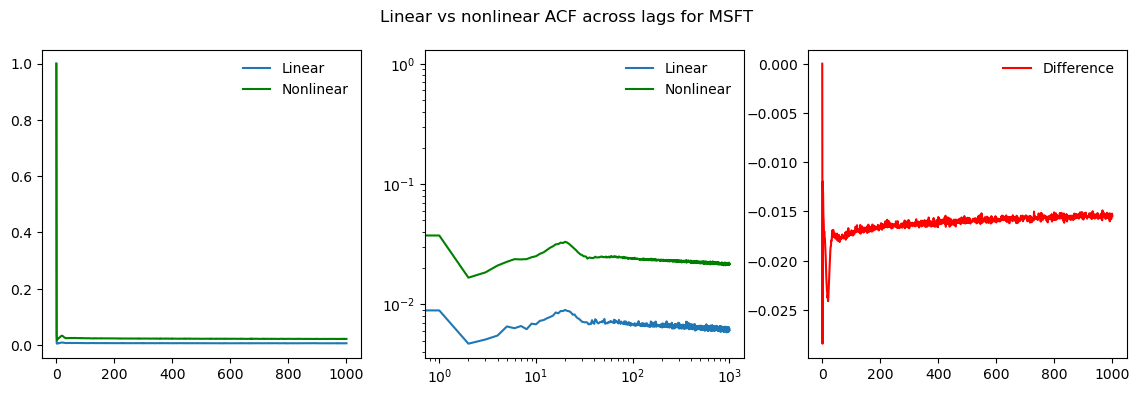

MSFT Max difference: 0.0


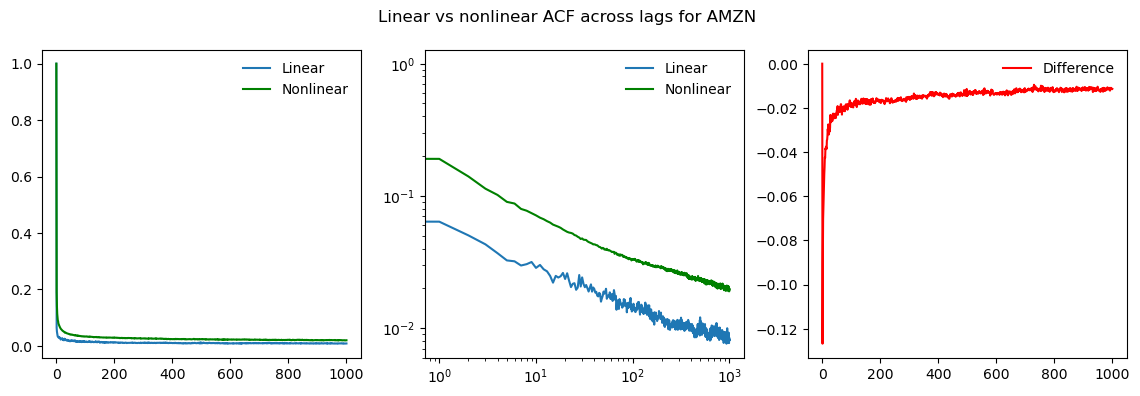

AMZN Max difference: 0.0


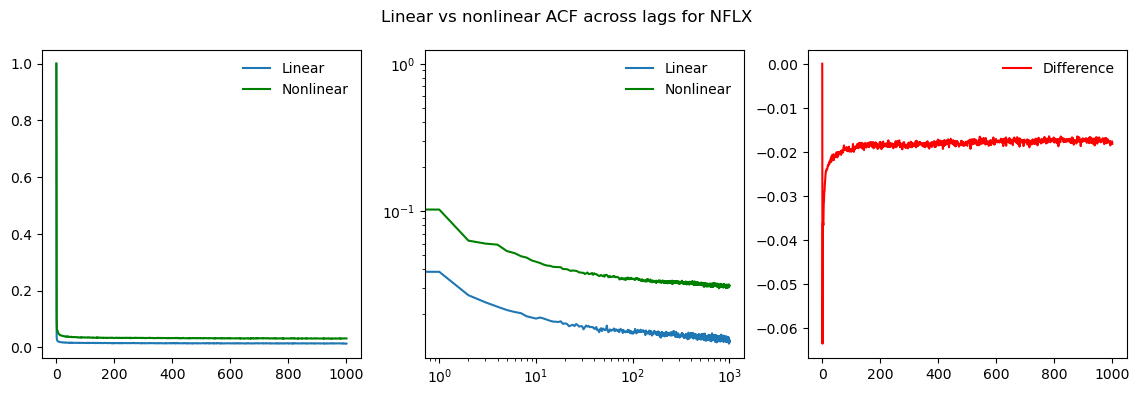

NFLX Max difference: 0.0


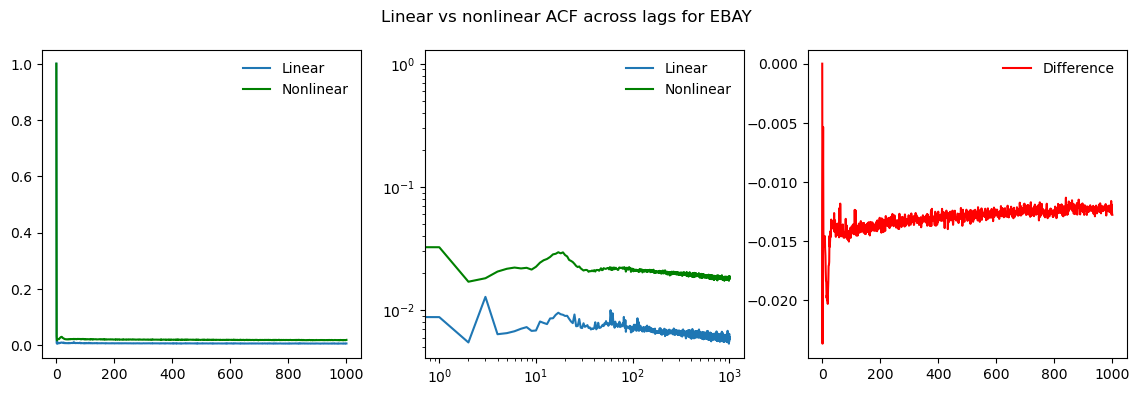

EBAY Max difference: -1.1102230246251565e-16


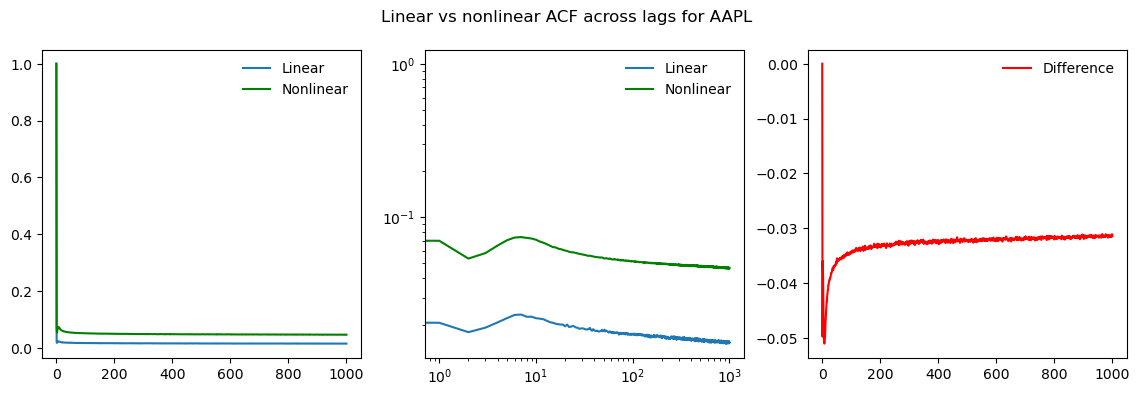

AAPL Max difference: 0.0


In [69]:
for stock_name in volatility_linear_acfs.keys():
    plot_acf_difference(stock_name, volatility_linear_acfs, volatility_nonlinear_acfs)

### 4.2. Fit power law to ACF

In [70]:
# Load the pre-computed ACFs
volatility_acf_values = {}

for stock, data in volatility_nonlinear_acfs.items():
    volatility_acf_values[stock] = construct_xy(data, stock)

In [71]:
# Using volatility_nonlinear_acfs
volatility_fit_results_list = []
volatility_fit_objects = {}  # Dictionary to store fit objects

for stock, data in volatility_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data)
    if fit_dict:
        volatility_fit_results_list.append(fit_dict)
        volatility_fit_objects[stock] = fit_obj  # Store the fit object

volatility_acf_fit_results = pd.DataFrame(volatility_fit_results_list)
display(volatility_acf_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0340406...",35,36.0,0.069358,-14653.262436,2.190672,0.903201,-0.112471,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0312875...",6,7.0,0.049246,-14548.423032,1.151907,0.756456,-0.054506,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0995406...",31,32.0,0.023711,-14709.292643,1.550709,0.989747,-0.234411,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0451830...",16,17.0,0.056853,-14964.635742,1.120563,0.909841,-0.056553,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0302561...",13,14.0,0.092105,-14699.428498,1.664064,0.832802,-0.074508,EBAY


In [72]:
avg_alpha = volatility_acf_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.09556685091625632


In [73]:
volatility_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])

### 4.3.Volatility Hurst Exponents

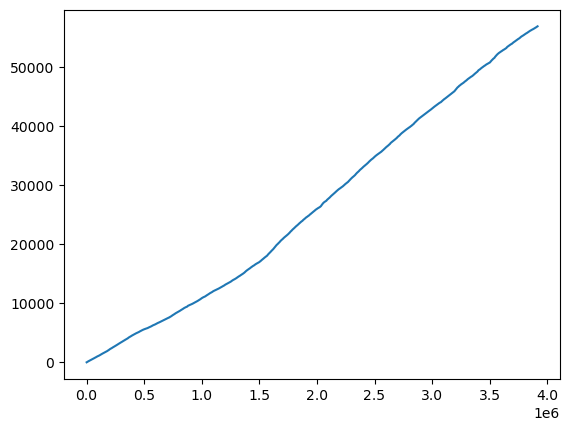

In [74]:
# Return magnitude (volatility)
tsla_volatility = compute_returns(tsla_raw_df)['volatility']
msft_volatility = compute_returns(msft_raw_df)['volatility']
amzn_volatility = compute_returns(amzn_raw_df)['volatility']
nflx_volatility = compute_returns(nflx_raw_df)['volatility']
ebay_volatility = compute_returns(ebay_raw_df)['volatility']
appl_volatility = compute_returns(appl_raw_df)['volatility']

cumsum_return_magnitudes = {
  'TSLA': tsla_volatility.cumsum(),
  'MSFT': msft_volatility.cumsum(),
  'AMZN': amzn_volatility.cumsum(),
  'NFLX': nflx_volatility.cumsum(),
  'EBAY': ebay_volatility.cumsum(),
  'AAPL': appl_volatility.cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_return_magnitudes = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_return_magnitudes.items()}
tsla_cumsum_abs_returns = tsla_volatility.cumsum()
x = list(range(1, len(tsla_cumsum_abs_returns)+1))
plt.plot(x, tsla_cumsum_abs_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [75]:
# Standard Hurst
method = 'standard'
volatility_fit_results_list = []
volatility_fit_objects = {}

for stock, data in cumsum_return_magnitudes.items():
    fit_dict, fit = compute_hurst_exponent('volatility', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        volatility_fit_results_list.append(fit_dict)
        volatility_fit_objects[(stock, method, 'volatility')] = fit

volatility_std_hurst_fit_results = pd.DataFrame(volatility_fit_results_list)
display(volatility_std_hurst_fit_results.head(10))

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0218816...",1,2.0,0.015581,-5146.927826,2.656132,0.998410,0.684732,TSLA,volatility
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0003143...",1,2.0,0.014164,-10726.741919,2.988755,0.998710,0.738969,MSFT,volatility
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0414398...",1,2.0,0.019830,-4453.529282,2.343481,0.998267,0.658767,AMZN,volatility
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0057456...",1,2.0,0.021246,-6046.702154,3.942224,0.996412,0.725185,NFLX,volatility
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0006483...",1,2.0,0.022663,-10841.205699,2.227674,0.998771,0.632748,EBAY,volatility
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0013185...",1,2.0,0.014164,-9181.036965,2.571704,0.998846,0.700056,AAPL,volatility


In [76]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = volatility_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.6900760752564574


#### Generalized Hurst

In [77]:
# Generalized Hurst
method = 'generalized'
volatility_fit_results_list = []
volatility_fit_objects = {}

for stock, data in cumsum_return_magnitudes.items():
    fit_dict, fit = compute_hurst_exponent('volatility', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        volatility_fit_results_list.append(fit_dict)
        volatility_fit_objects[(stock, method, 'volatility')] = fit

volatility_gen_hurst_fit_results = pd.DataFrame(volatility_fit_results_list)
display(volatility_gen_hurst_fit_results.head())

/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:151: UserWarning: Hurst exponent may not be in a valid range (-1, 1).
  warnings.warn("Hurst exponent may not be in a valid range (-1, 1).")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:151: UserWarning: Hurst exponent may not be in a valid range (-1, 1).
  warnings.warn("Hurst exponent may not be in a valid range (-1, 1).")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:151: UserWarning: Hurst exponent may not be in a valid range (-1, 1).
  warnings.warn("Hurst exponent may not be in a valid range (-1, 1).")


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0111527...",1,2.0,0.001416,-12347.033862,0.007588,1.0,1.000266,TSLA,volatility
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001360...",1,2.0,0.001416,-18556.699316,0.007422,1.0,0.999783,MSFT,volatility
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0153099...",1,2.0,0.001416,-13509.426557,0.001418,1.0,1.000072,AMZN,volatility
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0037587...",1,2.0,0.001416,-16146.211471,0.001989,1.0,0.999786,NFLX,volatility
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001042...",1,2.0,0.001416,-17287.942135,0.025467,1.0,0.999423,EBAY,volatility


In [78]:
# Generalized Hurst statistic across stocks
min_hurst_gen = volatility_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = volatility_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = volatility_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = volatility_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.9994228634541501
Max Generalized Hurst: 1.000266284384613
Average Generalized Hurst: 0.9998922153808123
Standard_dev Generalized Hurst: 0.0002943071849640459


In [79]:
print(volatility_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'volatility'), ('MSFT', 'generalized', 'volatility'), ('AMZN', 'generalized', 'volatility'), ('NFLX', 'generalized', 'volatility'), ('EBAY', 'generalized', 'volatility'), ('AAPL', 'generalized', 'volatility')])


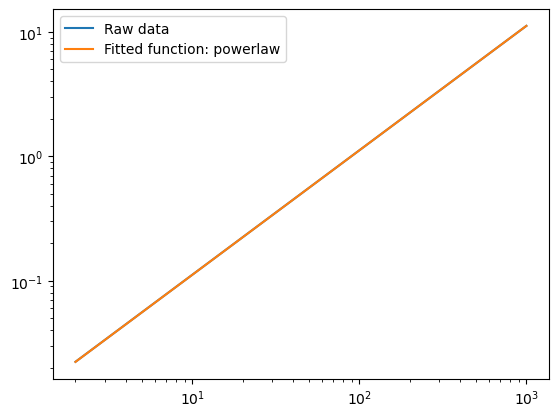

In [80]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = volatility_fit_objects[('TSLA', 'generalized', 'volatility')]
tsla_generalized_fit.powerlaw.plot_fit()